<a href="https://colab.research.google.com/github/kuberiitb/artificial_intelligence/blob/main/agent/AgentWithMemory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup packages

In [1]:
!pip install langchain langchain_community langchain-openai langgraph --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import os
from langchain.memory import ConversationBufferWindowMemory
from dotenv import load_dotenv
load_dotenv(".env")

True

In [3]:
from langchain.chat_models import ChatOpenAI

from langchain.chat_models import init_chat_model

if not os.environ["OPENAI_API_KEY"]:
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

/tmp/ipython-input-4154842141.py:8: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


In [4]:
llm.invoke("Hi").content

'Hello! How can I assist you today?'

## Built using tutorial [build basic chatbot](https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/#3-add-a-node) and [Add Memory](https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/#4-ask-a-follow-up-question)

In [24]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [25]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful assistant that answers user's query in short and simple language."),
            ("human", "{input}"),
        ]
    )
chain = prompt | llm

def chatbot(state: State):
  response = chain.invoke(
        {
            "input": state["messages"],
        }
    )
  return {"messages": [response.content]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [26]:
# Add an entry point to tell the graph where to start its work each time it is run:
graph_builder.add_edge(START, "chatbot")

In [27]:
# Add an exit point to indicate where the graph should finish execution.
graph_builder.add_edge("chatbot", END)

In [28]:
graph = graph_builder.compile()

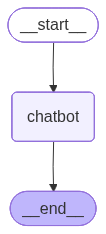

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

In [33]:
# run the graph in loop
questions = ["Who is India's prime minister?","What is his birthdate?","What about his mother's name?", "exit"]

idx = 0
while True:
    try:
        user_input = questions[idx] #input("User: ")
        idx+=1
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Who is India's prime minister?
Assistant: India's Prime Minister is Narendra Modi.
User: What is his birthdate?
Assistant: I need more context to answer that. Whose birthdate are you asking about?
User: What about his mother's name?
Assistant: I'm sorry, but I need more context to answer your question about his mother's name. Could you please provide more details?
User: exit
Goodbye!


# Adding Short term Memory

In [34]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [41]:
graph_with_memory = graph_builder.compile(checkpointer=memory)

### let's see how does it work.
#### It uses thread id to map the messages.

In [54]:
user_input = "Hi there! My name is Kuber."

# The config is the **second positional argument** to stream() or invoke()!
events = graph_with_memory.stream(
    {"messages": [{"role": "user", "content": user_input}]},
     {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Kuber.
================================ Human Message =================================

Hi Kuber! How can I help you today?


In [55]:
user_input = "Tell me what is my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me what is my name?
================================ Human Message =================================

Your name is Kuber! How can I assist you today?


## What happens if we change the thread id?

In [56]:
user_input = "Tell me what is my name again?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me what is my name again?
================================ Human Message =================================

I'm sorry, but I don't know your name. Can you tell me?


### Without correct thread it, memory will not work!!

### Let's add it to the function

In [57]:
config = {"configurable": {"thread_id": "2"}}

def stream_graph_updates(user_input: str):
    for event in graph_with_memory.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

In [58]:
# run the graph in loop
questions = ["Who is India's prime minister?","What is his birthdate?","What about his mother's name?", "exit"]

idx = 0
while True:
    try:
        user_input = questions[idx] #input("User: ")
        idx+=1
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Who is India's prime minister?
Assistant: India's Prime Minister is Narendra Modi.
User: What is his birthdate?
Assistant: Narendra Modi was born on September 17, 1950.
User: What about his mother's name?
Assistant: Narendra Modi's mother's name is Heeraben Modi.
User: exit
Goodbye!


# Great, now our chatbot has short term memory as well!!